Membangun sistem AI yang belajar dari data harga kendaraan bekas dan dapat memprediksi harga masa depan berdasarkan tren depresiasi

# Packages

In [1]:
!pip install transformers datasets torch scikit-learn==1.6.1
!pip install sentence-transformers
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 89.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvid

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Preprocessing Data

Rules
- Tidak menggunakan drop duplicates karena merk bisa sama dan harga berbeda
- Menggunakan fungsi untuk feature engineering yaitu tahun, nama merk dan harga (integer)
- normalisasi harga
- tahun akan diubah menjadi one-hot-encoding
- ada logic untuk depresiasi harga dengan 10% penurunan tiap tahun
  harga = harga_awal * (0.9) ** umur

In [ ]:
df = pd.read_csv('/kaggle/input/legoas-scrapping-otomotif/results.csv')
df

In [ ]:
# current year datetime dynamic
curent_year = datetime.now().year

# feature engineering
df['year'] = df['car_names'].str.extract(r'(\b\d{4}\b)')
df['car_names_clean'] = df['car_names'].str.replace(r'^\d{4}\s+', '', regex=True).str.split(r' - ').str[0].str.strip()
df['prices'] = df['car_prices'].str.replace(r'\D', '', regex=True).apply(lambda x: int(x) if x else None)
df['ages'] = df['year'].apply(lambda x: curent_year - int(x))
df['estimated_original_price'] = df.apply(
    lambda row: row['prices'] if row['ages'] == 0 else int(row['prices'] / (0.9 ** row['ages'])),
    axis=1
)
df['deprecate_percentage'] = ((df['estimated_original_price'] - df['prices']) / df['estimated_original_price'])
df

In [ ]:
feature_selected = df[['car_names_clean', 'prices', 'ages', 'estimated_original_price', 'deprecate_percentage','year']]
feature_selected

In [ ]:
feature_selected.to_csv('/kaggle/working/pemrosesan.csv', index=False)

# Modeling

In [3]:
import torch, joblib
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

2025-05-07 19:51:20.403766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746647480.840255      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746647480.968271      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv('/kaggle/working/pemrosesan.csv')
df

car_names_clean      prices  ages  \
0                       Mazda CX-5 2.5 Elite SUV   415000000     3   
1       Mitsubishi Xpander Cross 1.5 Premium MPV   222000000     6   
2                        Wuling Alvez 1.5 EX SUV   286000000     0   
3      Mitsubishi Pajero Sport 2.4 Dakar 4x2 SUV   450000000     3   
4                     Daihatsu Terios 1.5 TX SUV   111000000    16   
...                                          ...         ...   ...   
11820                   Hyundai IONIQ 6 Fastback  1020000000     1   
11821     Toyota Raize 1.0 GR Sport (2 Tone) SUV   200000000     3   
11822                    Toyota Sienta 1.5 G MPV   150000000     7   
11823  Mitsubishi Pajero Sport 2.4 Dakar 4X2 SUV   415000000     5   
11824                     Toyota Calya 1.2 G MPV   108000000     7   

       estimated_original_price  deprecate_percentage  year  
0                     569272976              0.271000  2022  
1                     417732165              0.468559  2019  
2                     286000000              0.000000  2025  
3                     617283950              0.271000  2022  
4                     599022075              0.814698  2009  
...                         ...                   ...   ...  
11820                1133333333              0.100000  2024  
11821                 274348422              0.271000  2022  
11822                 313612737              0.521703  2018  
11823                 702806144              0.409510  2020  
11824                 225801170              0.521703  2018  

[11825 rows x 6 columns]

In [5]:
# normalisasi, karena komputer sebatas bisa membaca angka 0-1 dan memudahkan komputasi 
p_scaler = MinMaxScaler()
eop_scaler = MinMaxScaler()
df['p_norm'] = p_scaler.fit_transform(df[['prices']])
df['eop_norm'] = eop_scaler.fit_transform(df[['estimated_original_price']])
df

car_names_clean      prices  ages  \
0                       Mazda CX-5 2.5 Elite SUV   415000000     3   
1       Mitsubishi Xpander Cross 1.5 Premium MPV   222000000     6   
2                        Wuling Alvez 1.5 EX SUV   286000000     0   
3      Mitsubishi Pajero Sport 2.4 Dakar 4x2 SUV   450000000     3   
4                     Daihatsu Terios 1.5 TX SUV   111000000    16   
...                                          ...         ...   ...   
11820                   Hyundai IONIQ 6 Fastback  1020000000     1   
11821     Toyota Raize 1.0 GR Sport (2 Tone) SUV   200000000     3   
11822                    Toyota Sienta 1.5 G MPV   150000000     7   
11823  Mitsubishi Pajero Sport 2.4 Dakar 4X2 SUV   415000000     5   
11824                     Toyota Calya 1.2 G MPV   108000000     7   

       estimated_original_price  deprecate_percentage  year    p_norm  \
0                     569272976              0.271000  2022  0.001652   
1                     417732165              0.468559  2019  0.000884   
2                     286000000              0.000000  2025  0.001139   
3                     617283950              0.271000  2022  0.001792   
4                     599022075              0.814698  2009  0.000442   
...                         ...                   ...   ...       ...   
11820                1133333333              0.100000  2024  0.004061   
11821                 274348422              0.271000  2022  0.000796   
11822                 313612737              0.521703  2018  0.000597   
11823                 702806144              0.409510  2020  0.001652   
11824                 225801170              0.521703  2018  0.000430   

       eop_norm  
0      0.001338  
1      0.000982  
2      0.000672  
3      0.001451  
4      0.001408  
...         ...  
11820  0.002665  
11821  0.000645  
11822  0.000737  
11823  0.001652  
11824  0.000531  

[11825 rows x 8 columns]

In [6]:
joblib.dump(p_scaler, "/kaggle/working/price_norm.pkl")
joblib.dump(eop_scaler, "/kaggle/working/eop_norm.pkl")

['/kaggle/working/eop_norm.pkl']

In [7]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
car_names_embeddings = bert_model.encode(df['car_names_clean'].tolist(), show_progress_bar=True)
car_names_df = pd.DataFrame(car_names_embeddings, columns=[f'bert_{i}' for i in range(car_names_embeddings.shape[1])])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/370 [00:00<?, ?it/s]

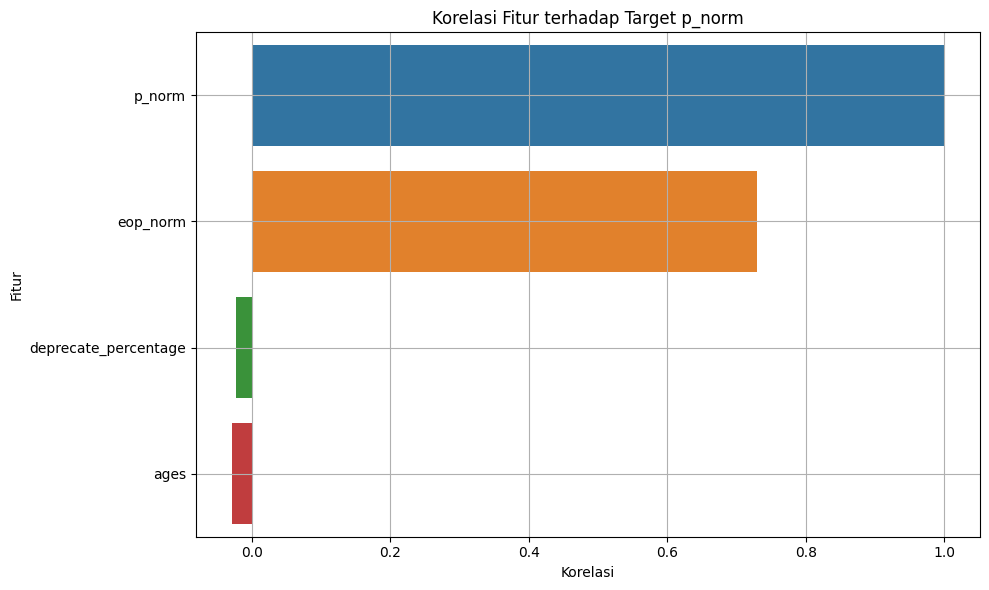

p_norm                  1.000000
eop_norm                0.730175
deprecate_percentage   -0.022325
ages                   -0.028863
Name: p_norm, dtype: float64

In [8]:
analysis_df = pd.concat([df[['p_norm' , 'eop_norm', 'ages', 'deprecate_percentage']]], axis=1)

correlations = analysis_df.corr(numeric_only=True)['p_norm'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Korelasi Fitur terhadap Target p_norm')
plt.xlabel('Korelasi')
plt.ylabel('Fitur')
plt.grid(True)
plt.tight_layout()
plt.show()

correlations.head(10)

In [9]:
X = pd.concat([car_names_df, df[['eop_norm', 'ages']].reset_index(drop=True)], axis=1)
y = df['p_norm']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
X_train

bert_0    bert_1    bert_2    bert_3    bert_4    bert_5    bert_6  \
11378 -0.029470 -0.013234 -0.041143 -0.077063  0.026463  0.027834 -0.050274   
10383 -0.114898  0.106321 -0.001228  0.049948 -0.084037  0.012905 -0.019098   
6106  -0.056078 -0.041918 -0.029557 -0.082310  0.018389  0.034702 -0.072229   
11605 -0.013787  0.090064 -0.060155  0.045836 -0.021725 -0.035984  0.042096   
1451  -0.017672  0.009427 -0.010428 -0.034253  0.012339  0.030820 -0.008325   
...         ...       ...       ...       ...       ...       ...       ...   
9079  -0.006589  0.065311 -0.084001  0.045546 -0.001115 -0.023570 -0.004520   
8966   0.000738  0.005126 -0.024787  0.088250  0.054263 -0.008861 -0.047321   
1818   0.002087 -0.030689 -0.024057 -0.034905  0.054794  0.021325 -0.003245   
1629  -0.028334  0.006627 -0.034478 -0.008797  0.041649  0.038520  0.030150   
10768  0.020114 -0.015322 -0.012969 -0.066782  0.063144  0.054644 -0.021472   

         bert_7    bert_8    bert_9  ...  bert_376  bert_377  bert_378  \
11378  0.031605 -0.003844  0.016589  ... -0.063193  0.065644 -0.057080   
10383  0.118853 -0.006946 -0.044849  ... -0.038572  0.093288 -0.036840   
6106   0.045174 -0.078204 -0.050956  ... -0.010363  0.088272 -0.067078   
11605  0.078376 -0.027304 -0.036993  ...  0.011080  0.027116 -0.027053   
1451   0.042181 -0.021712 -0.017776  ... -0.044356  0.066460 -0.077470   
...         ...       ...       ...  ...       ...       ...       ...   
9079   0.047788 -0.083888 -0.026300  ... -0.004477 -0.015251 -0.071699   
8966  -0.011977 -0.055715  0.041752  ...  0.007776 -0.033882 -0.043081   
1818   0.047044 -0.026661  0.024959  ... -0.052493  0.039645 -0.044388   
1629   0.124965 -0.036034  0.007961  ...  0.033675 -0.004588 -0.044272   
10768  0.017250  0.015408 -0.004987  ... -0.048061  0.102294 -0.041882   

       bert_379  bert_380  bert_381  bert_382  bert_383  eop_norm  ages  
11378 -0.018810  0.041155  0.026669 -0.023711  0.013544  0.001236     4  
10383 -0.013068  0.022624  0.001857 -0.011609 -0.008182  0.002801     2  
6106  -0.078614  0.004449 -0.020617 -0.007253  0.090385  0.000987     6  
11605 -0.004418  0.048515  0.030234 -0.105104  0.006796  0.001058     1  
1451  -0.044359  0.021946  0.009875 -0.039396  0.026865  0.000720     0  
...         ...       ...       ...       ...       ...       ...   ...  
9079  -0.046150 -0.010536  0.025932 -0.077295  0.021511  0.003156     1  
8966  -0.022249 -0.047681 -0.022898 -0.035075  0.022517  0.001959     1  
1818  -0.023784  0.004011 -0.025987 -0.015762  0.003220  0.003932     8  
1629  -0.052477  0.076229 -0.010224  0.011423  0.048818  0.000363     2  
10768 -0.041273  0.020969 -0.015416  0.016927  0.026058  0.001368     0  

[9460 rows x 386 columns]

In [12]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 0.0001
RMSE: 0.0006
R²: 0.9754


In [13]:
check_df = pd.DataFrame({'pred': y_pred, 'label': y_test})
check_df

pred     label
2987   0.000661  0.000661
6075   0.002270  0.002270
4156   0.001119  0.001119
8111   0.001394  0.001394
8080   0.001113  0.001115
...         ...       ...
1704   0.001199  0.001194
5150   0.001416  0.001425
11731  0.001097  0.001095
11002  0.000549  0.000549
10663  0.002886  0.002887

[2365 rows x 2 columns]

In [14]:
joblib.dump(model, 'model.pkl')


['model.pkl']

# Test

In [15]:
# contoh testing
test = {
    'car_names': ['2025 Mitsubishi Pajero Sport Dakar Ultimate (4X4) AT', '2022 Mitsubishi Expander Ultimate CVT'],
    'car_prices': ['Rp 764.200.000', 'Rp331.950.000']
}
test_df = pd.DataFrame(test)
test_df

car_names      car_prices
0  2025 Mitsubishi Pajero Sport Dakar Ultimate (4...  Rp 764.200.000
1              2022 Mitsubishi Expander Ultimate CVT   Rp331.950.000

In [16]:
# current year datetime dynamic
curent_year = datetime.now().year

# feature engineering
test_df['year'] = test_df['car_names'].str.extract(r'(\b\d{4}\b)')
test_df['car_names_clean'] = test_df['car_names'].str.replace(r'^\d{4}\s+', '', regex=True).str.split(r' - ').str[0].str.strip()
test_df['prices'] = test_df['car_prices'].str.replace(r'\D', '', regex=True).apply(lambda x: int(x) if x else None)
test_df['ages'] = test_df['year'].apply(lambda x: curent_year - int(x))
test_df['estimated_original_price'] = test_df.apply(
    lambda row: row['prices'] if row['ages'] == 0 else int(row['prices'] / (0.9 ** row['ages'])),
    axis=1
)
test_df['deprecate_percentage'] = ((test_df['estimated_original_price'] - test_df['prices']) / test_df['estimated_original_price'])
test_df

car_names      car_prices  year  \
0  2025 Mitsubishi Pajero Sport Dakar Ultimate (4...  Rp 764.200.000  2025   
1              2022 Mitsubishi Expander Ultimate CVT   Rp331.950.000  2022   

                                   car_names_clean     prices  ages  \
0  Mitsubishi Pajero Sport Dakar Ultimate (4X4) AT  764200000     0   
1                 Mitsubishi Expander Ultimate CVT  331950000     3   

   estimated_original_price  deprecate_percentage  
0                 764200000                 0.000  
1                 455349794                 0.271

In [17]:
p_scaler = joblib.load('price_norm.pkl')
eop_scaler = joblib.load('eop_norm.pkl')

test_df['p_norm'] = p_scaler.transform(test_df[['prices']])
test_df['eop_norm'] = eop_scaler.transform(test_df[['estimated_original_price']])
test_df

car_names      car_prices  year  \
0  2025 Mitsubishi Pajero Sport Dakar Ultimate (4...  Rp 764.200.000  2025   
1              2022 Mitsubishi Expander Ultimate CVT   Rp331.950.000  2022   

                                   car_names_clean     prices  ages  \
0  Mitsubishi Pajero Sport Dakar Ultimate (4X4) AT  764200000     0   
1                 Mitsubishi Expander Ultimate CVT  331950000     3   

   estimated_original_price  deprecate_percentage    p_norm  eop_norm  
0                 764200000                 0.000  0.003043  0.001797  
1                 455349794                 0.271  0.001322  0.001071

In [18]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
car_names_embeddings = bert_model.encode(test_df['car_names_clean'].tolist(), show_progress_bar=True)
car_names_df = pd.DataFrame(car_names_embeddings, columns=[f'bert_{i}' for i in range(car_names_embeddings.shape[1])])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
test_input = pd.concat([car_names_df, test_df[['eop_norm', 'ages']].reset_index(drop=True)], axis=1)
test_input

bert_0    bert_1    bert_2    bert_3    bert_4    bert_5    bert_6  \
0  0.014066  0.086013 -0.082927 -0.061399 -0.053758  0.035179 -0.010706   
1 -0.099028 -0.024163 -0.014358 -0.033732  0.055197 -0.001037 -0.047434   

     bert_7    bert_8    bert_9  ...  bert_376  bert_377  bert_378  bert_379  \
0  0.091782 -0.015837  0.025600  ... -0.013559  0.080615 -0.132412 -0.047983   
1  0.204618 -0.023997 -0.052195  ...  0.008176  0.049285 -0.047141  0.001278   

   bert_380  bert_381  bert_382  bert_383  eop_norm  ages  
0  0.037217 -0.044200 -0.040456  0.087468  0.001797     0  
1 -0.053189 -0.036602 -0.017618  0.066720  0.001071     3  

[2 rows x 386 columns]

In [20]:
model = joblib.load('model.pkl')
test_result = model.predict(test_input)

In [21]:
# hasil prediksi
check_df_1 = pd.DataFrame({'pred': test_result, 'label': test_df['p_norm']})
check_df_1

pred     label
0  0.003007  0.003043
1  0.001382  0.001322

1. feature -> estimate origin price, age and car names
2. result -> MAE: 0.0001, RMSE: 0.0006, R²: 0.9754